In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind
Hours_spent = pd.read_csv('Data_source\\All_Student_Uplearn_Hours.csv')
Hours_spent.rename(columns={'Student name': 'Student'}, inplace=True)
Year_12_grades = pd.read_csv('Data_source\\Year_12_attendance_and_attainment.csv')
Year_13_grades = pd.read_csv('Data_Source\\Year_13_attendance_and_attainment.csv')

In [ ]:
#There were a lot of unnecessary columns in the imported data so I removed them first.
Hours_spent= Hours_spent[['Student','Year','Total hours','Avg. sections completed',	'Avg. section score']]
Year_12_grades=Year_12_grades[['Student','Sex','SEN', 'EAL', 'PP','Autumn Term: Yr12 Chemistry PPE' ]]
Year_13_grades=Year_13_grades[['Student','Sex','SEN', 'EAL', 'PP', 'Autumn Term: Yr13 Chemistry Attainment', 'Spring Term: Yr13 Chemistry Attainment']]

def reformat_name(Student):
    parts=Student.split()
    if len(parts) ==3:
        return f'{parts[2]}, {parts[0]}'
    elif len(parts) == 2:
        return f'{parts[1]}, {parts[0]}'
    return Student

#There was an issue with the names as the data from the revision website had a different name formatting versus the achievement data of students which made it hard to merge the two datasets together for each year group. Another issue was dealing with middle names as well.
Hours_spent['Student'] = Hours_spent['Student'].apply(reformat_name)

In [13]:
merged_df = Hours_spent.merge(Year_12_grades, on='Student', how='left').merge(Year_13_grades, on='Student', how='left')

#Initially I wanted to have Year 12 and 13 on the same table so I merged both tables but found some columns repeating themselves.
merged_df['Sex'] = merged_df['Sex_x'].combine_first(merged_df['Sex_y'])
merged_df = merged_df.drop(columns=['Sex_x', 'Sex_y'])

merged_df['SEN'] = merged_df['SEN_x'].combine_first(merged_df['SEN_y'])
merged_df = merged_df.drop(columns=['SEN_x', 'SEN_y'])

merged_df['EAL'] = merged_df['EAL_x'].combine_first(merged_df['EAL_y'])
merged_df = merged_df.drop(columns=['EAL_x', 'EAL_y'])

merged_df['PP'] = merged_df['PP_x'].combine_first(merged_df['PP_y'])
merged_df = merged_df.drop(columns=['PP_x', 'PP_y'])

merged_df_sorted = merged_df.sort_values(by='Year', ascending=True)
merged_df_sorted = merged_df_sorted.fillna('-')
merged_df_sorted_reordered = merged_df_sorted.reindex(columns=['Student','Year','Sex', 'SEN', 'EAL', 'PP', 'Total hours', 'Avg. sections completed', 'Avg. section score', 'Autumn Term: Yr12 Chemistry PPE', 'Autumn Term: Yr13 Chemistry Attainment', 'Spring Term: Yr13 Chemistry Attainment'])

#To account for control variables in this investigation, I removed students that were identified to be EAL or SEN learners.
sample = merged_df_sorted_reordered[merged_df_sorted_reordered['EAL'] !='✓']
sample = sample[sample['SEN'] !='✓']

#By this point in the project, I reevaluated my research questions and decided it would be best for the tables to be seperated for each year group for separate analysis.
df_y12 = sample[sample['Year']==12].copy()
df_y12 = df_y12.drop(columns='Autumn Term: Yr13 Chemistry Attainment')
df_y12 = df_y12.drop(columns='Spring Term: Yr13 Chemistry Attainment')
df_y13 = sample[sample['Year']==13].copy()
df_y13 = df_y13.drop(columns='Autumn Term: Yr12 Chemistry PPE')

#For analysis to be done, str data must be converted to int
grade_mapping = {
    'A*': 7,
    'A': 6,
    'B': 5,
    'C': 4,
    'D': 3,
    'E': 2,
    'U': 1,
    '-': None  # For missing or not available
}

section_score_mapping = {
    'Outstanding score' : 3,
    'High score' : 2,
    'Medium score' : 1,
    'Low score' : 0,
    '-': None  # For missing or not available
    }

df_y13['Autumn Term: Yr13 Chemistry Attainment'] = df_y13['Autumn Term: Yr13 Chemistry Attainment'].map(grade_mapping)
df_y13['Spring Term: Yr13 Chemistry Attainment'] = df_y13['Spring Term: Yr13 Chemistry Attainment'].map(grade_mapping)
df_y13['Avg. section score'] = df_y13['Avg. section score'].map(section_score_mapping)

df_y12['Autumn Term: Yr12 Chemistry PPE'] = df_y12['Autumn Term: Yr12 Chemistry PPE'].map(grade_mapping)
df_y12['Avg. section score'] = df_y12['Avg. section score'].map(section_score_mapping)

# Remove the '%' and convert to float
df_y13['Avg. sections completed'] = df_y13['Avg. sections completed'].str.replace('%', '').astype(float)
df_y12['Avg. sections completed'] = df_y12['Avg. sections completed'].str.replace('%', '').astype(float)

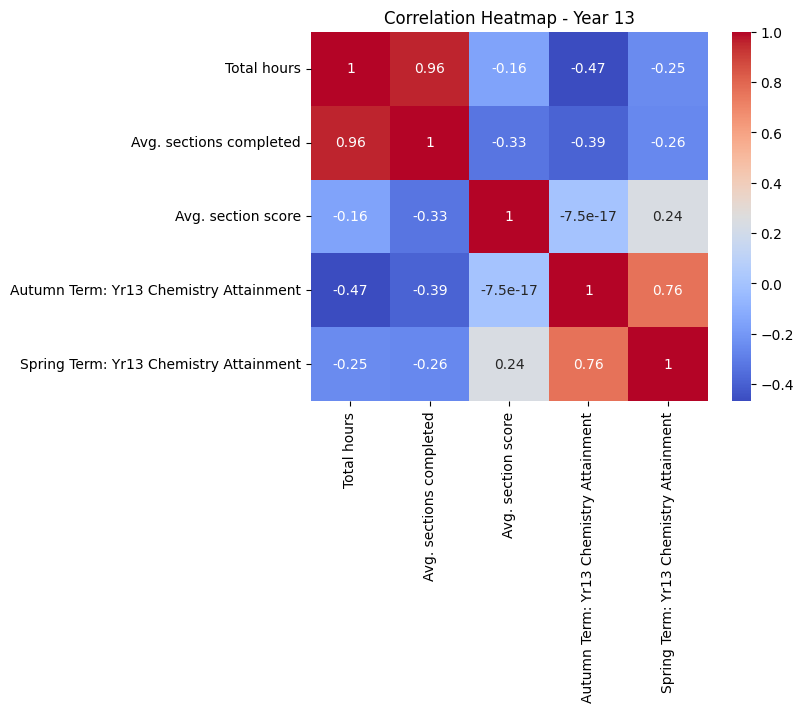

In [10]:
#Correlation analysis
df_y13[['Total hours', 'Autumn Term: Yr13 Chemistry Attainment']].corr()
df_y13[['Avg. section score', 'Autumn Term: Yr13 Chemistry Attainment']].corr()
df_y13[['Avg. sections completed', 'Autumn Term: Yr13 Chemistry Attainment']].corr()

df_y13[['Total hours', 'Spring Term: Yr13 Chemistry Attainment']].corr()
df_y13[['Avg. section score', 'Spring Term: Yr13 Chemistry Attainment']].corr()
df_y13[['Avg. sections completed', 'Spring Term: Yr13 Chemistry Attainment']].corr()

df_y12[['Total hours', 'Autumn Term: Yr12 Chemistry PPE']].corr()
df_y12[['Avg. section score', 'Autumn Term: Yr12 Chemistry PPE']].corr()
df_y12[['Avg. sections completed', 'Autumn Term: Yr12 Chemistry PPE']].corr()

corr_matrix_y13 = df_y13[['Total hours', 'Avg. sections completed', 'Avg. section score', 'Autumn Term: Yr13 Chemistry Attainment', 'Spring Term: Yr13 Chemistry Attainment']].corr()

sns.heatmap(corr_matrix_y13, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Year 13')
plt.show()

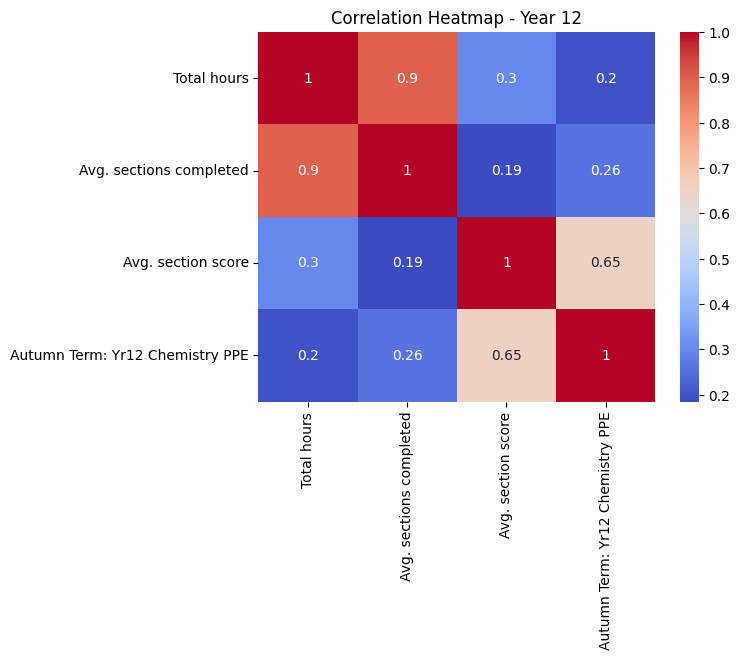

In [60]:
corr_matrix_y12 = df_y12[['Total hours', 'Avg. sections completed', 'Avg. section score', 'Autumn Term: Yr12 Chemistry PPE']].corr()
sns.heatmap(corr_matrix_y12, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Year 12')
plt.show()

                                   OLS Regression Results                                  
Dep. Variable:     Autumn Term: Yr12 Chemistry PPE   R-squared:                         nan
Model:                                         OLS   Adj. R-squared:                    nan
Method:                              Least Squares   F-statistic:                       nan
Date:                             Sun, 16 Mar 2025   Prob (F-statistic):                nan
Time:                                     22:11:44   Log-Likelihood:                    nan
No. Observations:                               11   AIC:                               nan
Df Residuals:                                    9   BIC:                               nan
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      

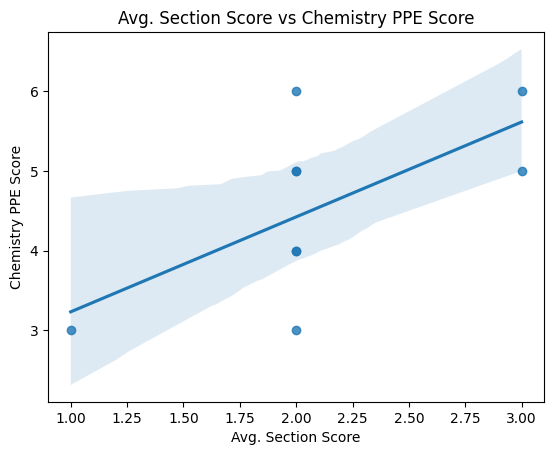

In [11]:
#Simple Regression Analysis
X = df_y12[['Avg. section score']]
y = df_y12['Autumn Term: Yr12 Chemistry PPE']
X = sm.add_constant(X)
y12_model = sm.OLS(y, X).fit()
print(y12_model.summary())

sns.regplot(x='Avg. section score', y='Autumn Term: Yr12 Chemistry PPE', data = df_y12)
plt.title('Avg. Section Score vs Chemistry PPE Score')
plt.xlabel('Avg. Section Score')
plt.ylabel('Chemistry PPE Score')
plt.show()


T-statistic: 2.431
P-value: 0.0379
4.888888888888889 3.0


c:\Users\DemMangoes\Documents\GitHub\uplearn_project\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


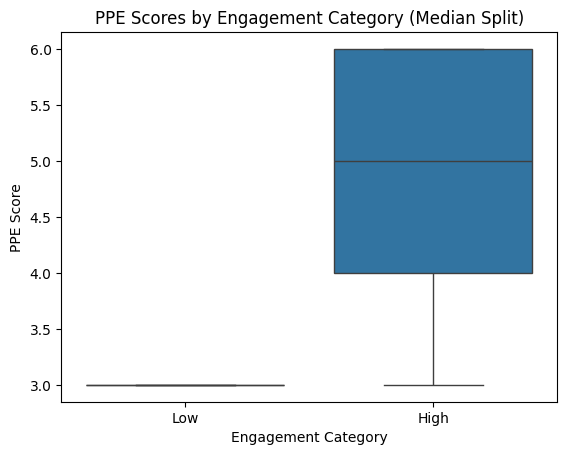

In [86]:
#T-test using median split (more appropriate for smaller dataset)

median_score = df_y12['Avg. section score'].median()
df_y12['Engagement Category'] = df_y12['Avg. section score'].apply(
    lambda x: 'High' if x >= median_score else 'Low'
)

high = df_y12[df_y12['Engagement Category'] == 'High']['Autumn Term: Yr12 Chemistry PPE']
low = df_y12[df_y12['Engagement Category'] == 'Low']['Autumn Term: Yr12 Chemistry PPE']

t_stat, p_val = ttest_ind(high, low)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")
print(high.mean(), low.mean())

sns.boxplot(x='Engagement Category', y='Autumn Term: Yr12 Chemistry PPE', data=df_y12)
plt.title('PPE Scores by Engagement Category (Median Split)')
plt.ylabel('PPE Score')
plt.xlabel('Engagement Category')
plt.show()


T-statistic: 1.131
P-value: 0.3011
4.285714285714286 2.0


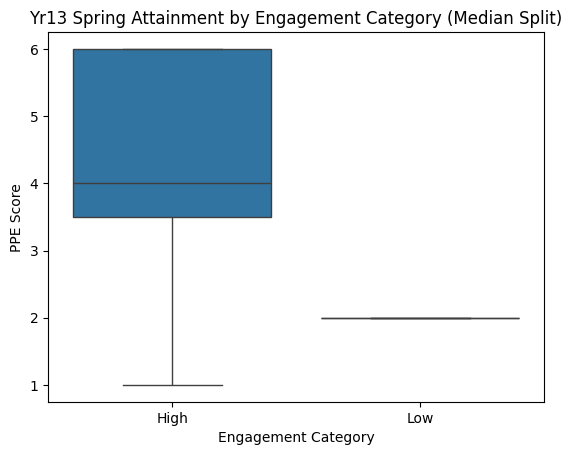

In [12]:
median_score = df_y13['Avg. section score'].median()
df_y13['Engagement Category'] = df_y13['Avg. section score'].apply(
    lambda x: 'High' if x >= median_score else 'Low'
)

high = df_y13[df_y13['Engagement Category'] == 'High']['Spring Term: Yr13 Chemistry Attainment']
low = df_y13[df_y13['Engagement Category'] == 'Low']['Spring Term: Yr13 Chemistry Attainment']

t_stat, p_val = ttest_ind(high, low)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")
print(high.mean(), low.mean())

sns.boxplot(x='Engagement Category', y='Spring Term: Yr13 Chemistry Attainment', data=df_y13)
plt.title('Yr13 Spring Attainment by Engagement Category (Median Split)')
plt.ylabel('PPE Score')
plt.xlabel('Engagement Category')
plt.show()

In [88]:
#Higher UpLearn section scores are strongly associated with better performance in the Yr12 Autumn Chemistry PPE.
#A 1-point increase in Avg. Section Score predicts +1.25 improvement in Chemistry PPE grade.
#R-square suggests there may be other variables involved.
#Limited by sample size and too similar values (affected t-test)
#T-test shows that students with higher UpLearn engagement achieved significantly higher grades than those with lower engagement.

In [92]:
df_y12.to_csv("Year_12_Uplearn_cleaned.csv", index=False)
df_y13.to_csv("Year_13_Uplearn_cleaned.csv", index = False)